<a href="https://www.kaggle.com/code/mauddib/0-97-predict-the-introverts-imputation-lightgbm?scriptVersionId=252894965" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Table of Contents

1. [Load data](#loaddata)
2. [Create dummies and impute missing values](#impute)
3. [Create and visualize some score features](#viz)
4. [Train model](#load)
5. [confusion matrix](#cf)
6. [Submission file](#get)

!!Pls load a gpu enabled environment!!

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
tqdm.pandas()
import warnings
warnings.filterwarnings("ignore")
from scipy.sparse import hstack 
from textblob import TextBlob
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import accuracy_score
import lightgbm as lgb
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import langid
from sklearn.metrics import roc_auc_score as ras
import string

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e7/sample_submission.csv
/kaggle/input/playground-series-s5e7/train.csv
/kaggle/input/playground-series-s5e7/test.csv


# 1. Load data <a class="anchor"  id="loaddata"></a>

In [2]:
train = pd.read_csv('/kaggle/input/playground-series-s5e7/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s5e7/test.csv')
train.head(2)

,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
0,0,0.0,No,6.0,4.0,No,15.0,5.0,Extrovert
1,1,1.0,No,7.0,3.0,No,10.0,8.0,Extrovert


In [3]:
test.head(2)

,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency
0,18524,3.0,No,7.0,4.0,No,6.0,NaN
1,18525,NaN,Yes,0.0,0.0,Yes,5.0,1.0


Hmmm i see missing values. Let's assess the full scope of the issue:

In [4]:
print(len(test))
print(test.isna().sum())
print(train.isna().sum())

6175
id                             0
Time_spent_Alone             425
Stage_fear                   598
Social_event_attendance      397
Going_outside                466
Drained_after_socializing    432
Friends_circle_size          350
Post_frequency               408
dtype: int64
id                              0
Time_spent_Alone             1190
Stage_fear                   1893
Social_event_attendance      1180
Going_outside                1466
Drained_after_socializing    1149
Friends_circle_size          1054
Post_frequency               1264
Personality                     0
dtype: int64


# 2. Get dummies and Impute <a class="anchor"  id="impute"></a>

In [5]:
classdummies = pd.get_dummies(train.Stage_fear)

train = pd.concat([train, classdummies], axis=1)
train.rename(columns={'No': 'Stage_fear_No', 'Yes': 'Stage_fear_Yes'}, inplace=True)
train.head(2)

,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality,Stage_fear_No,Stage_fear_Yes
0,0,0.0,No,6.0,4.0,No,15.0,5.0,Extrovert,True,False
1,1,1.0,No,7.0,3.0,No,10.0,8.0,Extrovert,True,False


In [6]:
classdummies = pd.get_dummies(test.Stage_fear)

test = pd.concat([test, classdummies], axis=1)
test.rename(columns={'No': 'Stage_fear_No', 'Yes': 'Stage_fear_Yes'}, inplace=True)
test.head(2)

,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Stage_fear_No,Stage_fear_Yes
0,18524,3.0,No,7.0,4.0,No,6.0,NaN,True,False
1,18525,NaN,Yes,0.0,0.0,Yes,5.0,1.0,False,True


In [7]:
classdummies = pd.get_dummies(train.Drained_after_socializing)

train = pd.concat([train, classdummies], axis=1)
train.rename(columns={'No': 'Drained_after_socializing_No', 'Yes': 'Drained_after_socializing_Yes'}, inplace=True)
train.head(2)

,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality,Stage_fear_No,Stage_fear_Yes,Drained_after_socializing_No,Drained_after_socializing_Yes
0,0,0.0,No,6.0,4.0,No,15.0,5.0,Extrovert,True,False,True,False
1,1,1.0,No,7.0,3.0,No,10.0,8.0,Extrovert,True,False,True,False


In [8]:
classdummies = pd.get_dummies(test.Drained_after_socializing)

test = pd.concat([test, classdummies], axis=1)
test.rename(columns={'No': 'Drained_after_socializing_No', 'Yes': 'Drained_after_socializing_Yes'}, inplace=True)
test.head(2)

,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Stage_fear_No,Stage_fear_Yes,Drained_after_socializing_No,Drained_after_socializing_Yes
0,18524,3.0,No,7.0,4.0,No,6.0,NaN,True,False,True,False
1,18525,NaN,Yes,0.0,0.0,Yes,5.0,1.0,False,True,False,True


In [9]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.metrics import mean_squared_error

cont_feats = [col for col in train[['Time_spent_Alone','Stage_fear_No','Stage_fear_Yes'
                                    ,'Social_event_attendance','Going_outside','Drained_after_socializing_No'
                                    ,'Drained_after_socializing_Yes','Friends_circle_size','Post_frequency']].columns]

# Iterative Imputation

iter_imputer = IterativeImputer(random_state=42)
iter_imputed = iter_imputer.fit_transform(train[['Time_spent_Alone','Stage_fear_No','Stage_fear_Yes'
                                    ,'Social_event_attendance','Going_outside','Drained_after_socializing_No'
                                    ,'Drained_after_socializing_Yes','Friends_circle_size','Post_frequency']])
_columns = ['Time_spent_Alone','Stage_fear_No','Stage_fear_Yes'
                                    ,'Social_event_attendance','Going_outside','Drained_after_socializing_No'
                                    ,'Drained_after_socializing_Yes','Friends_circle_size','Post_frequency']
df_iter_imputed = pd.DataFrame(iter_imputed,columns = _columns)
train['Time_spent_Alone'] = df_iter_imputed['Time_spent_Alone']
train['Stage_fear_No'] = df_iter_imputed['Stage_fear_No']
train['Stage_fear_Yes'] = df_iter_imputed['Stage_fear_Yes']
train['Social_event_attendance'] = df_iter_imputed['Social_event_attendance']
train['Going_outside'] = df_iter_imputed['Going_outside']
train['Drained_after_socializing_No'] = df_iter_imputed['Drained_after_socializing_No']
train['Drained_after_socializing_Yes'] = df_iter_imputed['Drained_after_socializing_Yes']
train['Friends_circle_size'] = df_iter_imputed['Friends_circle_size']
train['Post_frequency'] = df_iter_imputed['Post_frequency']
train.isnull().sum()[:]

id                                  0
Time_spent_Alone                    0
Stage_fear                       1893
Social_event_attendance             0
Going_outside                       0
Drained_after_socializing        1149
Friends_circle_size                 0
Post_frequency                      0
Personality                         0
Stage_fear_No                       0
Stage_fear_Yes                      0
Drained_after_socializing_No        0
Drained_after_socializing_Yes       0
dtype: int64

In [10]:
cont_feats = [col for col in test[['Time_spent_Alone','Stage_fear_No','Stage_fear_Yes'
                                    ,'Social_event_attendance','Going_outside','Drained_after_socializing_No'
                                    ,'Drained_after_socializing_Yes','Friends_circle_size','Post_frequency']].columns]

# Iterative Imputation

iter_imputer = IterativeImputer(random_state=42)
iter_imputed = iter_imputer.fit_transform(test[['Time_spent_Alone','Stage_fear_No','Stage_fear_Yes'
                                    ,'Social_event_attendance','Going_outside','Drained_after_socializing_No'
                                    ,'Drained_after_socializing_Yes','Friends_circle_size','Post_frequency']])
_columns = ['Time_spent_Alone','Stage_fear_No','Stage_fear_Yes'
                                    ,'Social_event_attendance','Going_outside','Drained_after_socializing_No'
                                    ,'Drained_after_socializing_Yes','Friends_circle_size','Post_frequency']
df_iter_imputed = pd.DataFrame(iter_imputed,columns = _columns)
test['Time_spent_Alone'] = df_iter_imputed['Time_spent_Alone']
test['Stage_fear_No'] = df_iter_imputed['Stage_fear_No']
print('ihere')
test['Stage_fear_Yes'] = df_iter_imputed['Stage_fear_Yes']
test['Social_event_attendance'] = df_iter_imputed['Social_event_attendance']
test['Going_outside'] = df_iter_imputed['Going_outside']
test['Drained_after_socializing_No'] = df_iter_imputed['Drained_after_socializing_No']
test['Drained_after_socializing_Yes'] = df_iter_imputed['Drained_after_socializing_Yes']
test['Friends_circle_size'] = df_iter_imputed['Friends_circle_size']
test['Post_frequency'] = df_iter_imputed['Post_frequency']
test.isnull().sum()[:]

ihere


id                                 0
Time_spent_Alone                   0
Stage_fear                       598
Social_event_attendance            0
Going_outside                      0
Drained_after_socializing        432
Friends_circle_size                0
Post_frequency                     0
Stage_fear_No                      0
Stage_fear_Yes                     0
Drained_after_socializing_No       0
Drained_after_socializing_Yes      0
dtype: int64

# 3. Visualize the data <a class="anchor"  id="viz"></a>

In [11]:
def corrdot(*args, **kwargs):
    corr_r = args[0].corr(args[1], 'pearson')
    corr_text = f"{corr_r:2.2f}".replace("0.", ".")
    ax = plt.gca()
    ax.set_axis_off()
    marker_size = abs(corr_r) * 10000
    ax.scatter([.5], [.5], marker_size, [corr_r], alpha=0.6, cmap="coolwarm",
               vmin=-1, vmax=1, transform=ax.transAxes)
    font_size = abs(corr_r) * 40 + 5
    ax.annotate(corr_text, [.5, .5,],  xycoords="axes fraction",
                ha='center', va='center', fontsize=font_size)

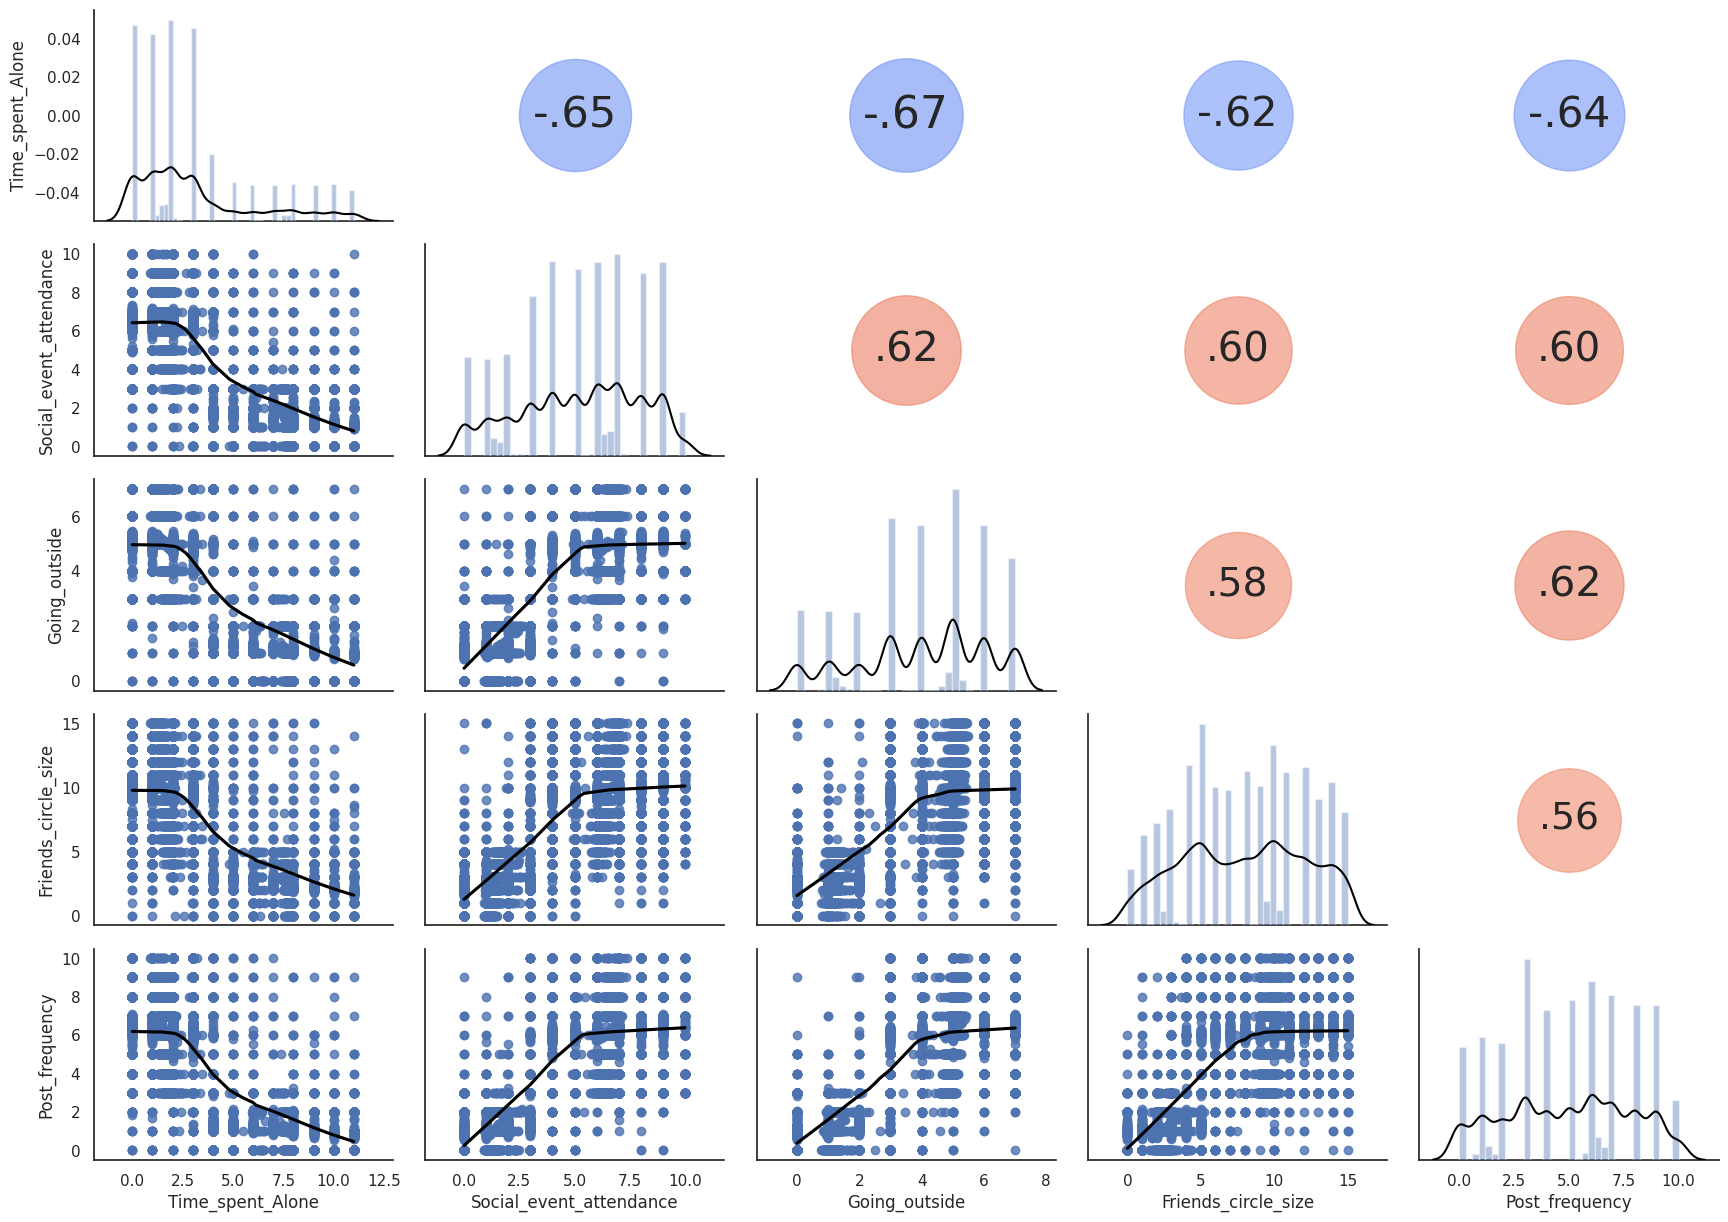

In [12]:
sns.set(style='white', font_scale=1.0)

g = sns.PairGrid(train[['Time_spent_Alone','Stage_fear','Social_event_attendance','Going_outside','Drained_after_socializing','Friends_circle_size','Post_frequency']], aspect=1.4, diag_sharey=False)
g.map_lower(sns.regplot, lowess=True, ci=False, line_kws={'color': 'black'})
g.map_diag(sns.distplot, kde_kws={'color': 'black'})
g.map_upper(corrdot)
plt.show()

# 4. Train model <a class="anchor"  id="load"></a>

In [13]:
test.dtypes

id                                 int64
Time_spent_Alone                 float64
Stage_fear                        object
Social_event_attendance          float64
Going_outside                    float64
Drained_after_socializing         object
Friends_circle_size              float64
Post_frequency                   float64
Stage_fear_No                    float64
Stage_fear_Yes                   float64
Drained_after_socializing_No     float64
Drained_after_socializing_Yes    float64
dtype: object

In [14]:
import warnings
warnings.filterwarnings("ignore")
train['Personality_'] = np.where(train['Personality'] == 'Introvert',1,0)
idx_train, idx_validation = train_test_split(train.index,test_size=0.10,stratify=train["Personality_"], random_state=7)
X_train, y_train = train.loc[idx_train],  train.loc[idx_train, 'Personality_']
X_val, y_val = train.loc[idx_validation],  train.loc[idx_validation, 'Personality_']


model = lgb.LGBMClassifier()
kf = KFold(n_splits=10)
scores = []
for train_index, val_index in kf.split(train):
    X_train, y_train = train.loc[idx_train],  train.loc[idx_train, 'Personality_']
    X_val, y_val = train.loc[idx_validation],  train.loc[idx_validation, 'Personality_']
    # Create LightGBM Dataset for training and validation
    X_train_all_features = X_train[['Time_spent_Alone','Stage_fear_No','Stage_fear_Yes'
                                        ,'Social_event_attendance','Going_outside','Drained_after_socializing_No'
                                        ,'Drained_after_socializing_Yes','Friends_circle_size','Post_frequency']]
    X_val_all_features = X_val[['Time_spent_Alone','Stage_fear_No','Stage_fear_Yes'
                                        ,'Social_event_attendance','Going_outside','Drained_after_socializing_No'
                                        ,'Drained_after_socializing_Yes','Friends_circle_size','Post_frequency']]
    model.fit(X_train_all_features, y_train)
    y_pred = model.predict(X_val_all_features)
    score = accuracy_score(y_val, y_pred)
    scores.append(score)
    print(f'Fold {len(scores)}, Accuracy: {score:.4f}')

[LightGBM] [Info] Number of positive: 4342, number of negative: 12329
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002739 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1283
[LightGBM] [Info] Number of data points in the train set: 16671, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.260452 -> initscore=-1.043619
[LightGBM] [Info] Start training from score -1.043619
Fold 1, Accuracy: 0.9676
[LightGBM] [Info] Number of positive: 4342, number of negative: 12329
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000595 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1283
[LightGBM] [Info] Number of data points in the train set: 16671, number of used features:

In [15]:
from sklearn.metrics import roc_auc_score
y_train_pred = model.predict(X_train_all_features)
y_val_pred = model.predict(X_val_all_features)
metric_train = roc_auc_score(y_train, y_train_pred)
metric_val = roc_auc_score(y_val, y_val_pred)
print(f"[auc] train:{metric_train},val:{metric_val}")

[auc] train:0.9614152000098334,val:0.9546440283507881


# 5. Confusion matrix <a class="anchor"  id="cf"></a>

In [16]:
print(len(y_train_pred))
print(len(X_val_all_features))

16671
1853


In [17]:
y_val_pred = model.predict(X_val_all_features)
cm_labels = np.unique(y_val)
cm_array = confusion_matrix(y_val.astype(int), y_val_pred)
cm_array_df = pd.DataFrame(cm_array, index=cm_labels, columns=cm_labels)

<Axes: >

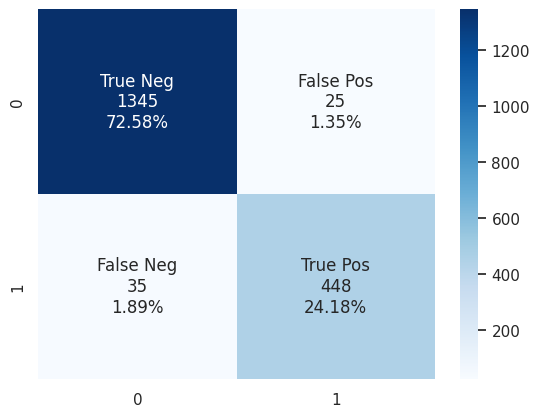

In [18]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cm_array.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cm_array.flatten()/np.sum(cm_array)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm_array, annot=labels, fmt='', cmap='Blues')

# 6. Submission time <a class="anchor"  id="get"></a>

In [19]:
test['Personality'] = np.where(model.predict(test[['Time_spent_Alone','Stage_fear_No','Stage_fear_Yes'
                                    ,'Social_event_attendance','Going_outside','Drained_after_socializing_No'
                                    ,'Drained_after_socializing_Yes','Friends_circle_size','Post_frequency']]) == 1,'Introvert','Extrovert')

sub=test[["id","Personality"]]
sub.head(2)

,id,Personality
0,18524,Extrovert
1,18525,Introvert


In [20]:
sub.to_csv("/kaggle/working/submission.csv",index=False)